In [2]:
import pickle
import numpy as np
import math
from sklearn.utils import shuffle
from sklearn import preprocessing
# Fix error with TF and Keras
import tensorflow as tf
tf.python.control_flow_ops = tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.activations import relu, softmax
import matplotlib.pyplot as plt
import csv
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from sklearn.cross_validation import train_test_split
import random
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, SpatialDropout2D
from keras.layers.core import Dropout, Lambda
from keras.layers import Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
import random
import math

%matplotlib inline
print('Modules loaded.')

Using TensorFlow backend.


Modules loaded.


/home/pratyushverma/installation/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
## Global Variables
pickle_file = "data.p"

In [3]:
# The following were the types of image pre-processing I tried, however they didn't result in good result.
# In the next cell, there is crop and resize operation which worked well.

# def grayscale(img):
#     """Applies the Grayscale transform
#     This will return an image with only one color channel
#     but NOTE: to see the returned image as grayscale
#     you should call plt.imshow(gray, cmap='gray')"""
#     return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     # Or use BGR2GRAY if you read an image with cv2.imread()
#     # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
# def canny(img, low_threshold, high_threshold):
#     """Applies the Canny transform"""
#     return cv2.Canny(img, low_threshold, high_threshold)

# def gaussian_blur(img, kernel_size):
#     """Applies a Gaussian Noise kernel"""
#     return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
            
# def hough_lines(img):
#     """
#     `img` should be the output of a Canny transform.
        
#     Returns an image with hough lines drawn.
#     """
#     lines = cv2.HoughLinesP(img, 1, np.pi/180, 10, np.array([]), minLineLength=20, maxLineGap=50)
#     line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
#     draw_lines(line_img, lines)
#     return line_img

# def transform_colorChannels(img, minH=0.8, maxH=1.2, minS=0.7, maxS=1, minV=0.40, maxV=1.2):
    
#     img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
#     random_H = minH + np.random.uniform()*(maxH-minH)
#     random_S = minS + np.random.uniform()*(maxS-minS)
#     random_V = minV + np.random.uniform()*(maxV-minV)
#     img[:,:,0] = img[:,:,0]*random_H
#     img[:,:,1] = img[:,:,1]*random_S
#     img[:,:,2] = img[:,:,2]*random_V
    
#     img = np.minimum(img, 255)
#     img = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
    
#     return img

# def transform_shift(img, steer, hShiftMin=-35, hShiftMax=35, vShiftMin=-10, vShiftMax=10 ):
    
#     random_hShift = hShiftMin + np.random.uniform()*(hShiftMax-hShiftMin)
#     random_vShift = vShiftMin + np.random.uniform()*(vShiftMax-vShiftMin)
    
#     shiftMatrix = np.float32( [[1,0,random_hShift], [0,1,random_vShift]] )
#     imgMod = cv2.warpAffine(img, shiftMatrix, (img.shape[1],img.shape[0]))
#     steerMod = steer + 0.01*random_hShift  # 0.01 rad (0.57 deg) per pixel
#     return imgMod,steerMod


# def process_image(img):
#     img1 = np.array(img)
# #    img = transform_colorChannels(img)
# #    img = cv2.cvtColor(img, cv2.CV_8UC3)
# #    cv2.fastNlMeansDenoisingColored(img,img1,15,10,21,7)
#     #im_bw = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]
# #     return im_bw
# #    img = gaussian_blur(img, 5)
# #    img = canny(img, 150, 255)
#     return img
# #     img = hough_lines(img)
    

In [4]:
# Here I crop the top and bommton part of the image, resize the image to 64x64 size and normalize the image
# Augmentation of data
# 1. Flip the image as well, in case of a flip the angle also is multiplies by -1

def get_img(img, y):
#     img = cv2.resize(img, (200, 100))
    img = process_image(img)
    img = img[55:135, :]
    img = cv2.resize(img, (64, 64))
    img = img / 255.0 - 0.5
    return y, img

def flip_img(img, y):
    return -1 * float(y), cv2.flip(img, 1)

In [5]:
# Prepare the dataset, preprocess the images and store in a pickle file so that it can be reused.
# I am flipping 50% of center images, 25% of left and 25% of right images, 
# to generate more images for training dataset

data = [[[[]]*1]*1]*1
labels = []
    
csv_file = "driving_log.csv"
delta = 0.30
with open(csv_file, 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    idx=0
    for row in reader:
        if idx == 0:
            idx = idx + 1
            continue
        rnd = random.randint(0,1)
        flip = random.randint(0,4)
        
        angle = float(row[3])
        full_path = row[0]
        img = cv2.imread(full_path)
        y1, i1 = get_img(img, angle)
        data.append(i1)
        labels.append(y1)
        
        if flip <= 2:
            y1, i1 = flip_img(i1, y1)
            data.append(i1)
            labels.append(y1)

        if row[1].strip() == "":
            continue
            
        
        left = row[1].strip()
        img = cv2.imread(left)
        y_left, i_left = get_img(img, angle + delta)
        data.append(i_left)
        labels.append(y_left)
        if flip == 3:
            y_left, i_left = flip_img(i_left, y_left)
            data.append(i_left)
            labels.append(y_left)
        
        
        right = row[2].strip()
        img = cv2.imread(right)
        y_right, i_right = get_img(img, angle - delta)
        data.append(i_right)
        labels.append(y_right)
        if flip == 4:
            y_right, i_right = flip_img(i_right, y_right)
            data.append(i_right)
            labels.append(y_right)
        

        idx=idx+1


data.pop(0)
X_data = np.array(data)
y_data = np.array(labels)
print(X_data.shape)
print(y_data.shape)
data = {
    "X_data": X_data,
    "y_data": y_data
}
#rnd = random.randrange(len(X_data))
#print("Random index {}".format(rnd))
#plt.imshow(X_data[rnd])
pickle.dump(data, open(pickle_file, "wb"))


(32144, 64, 64, 3)
(32144,)


In [5]:
with open(pickle_file, mode='rb') as f:
    data = pickle.load(f)

X_train, y_train = data['X_data'], data['y_data']
print(X_train.shape)
print(y_train.shape)
print(len(np.unique(y_train)))
nb_classes = 1

(32144, 64, 64, 3)
(32144,)
678


In [6]:
imgshape=X_train[0].shape
print(imgshape)

(64, 64, 3)


len(y) : 32144
y.min() : -1.3
y.max() : 1.3


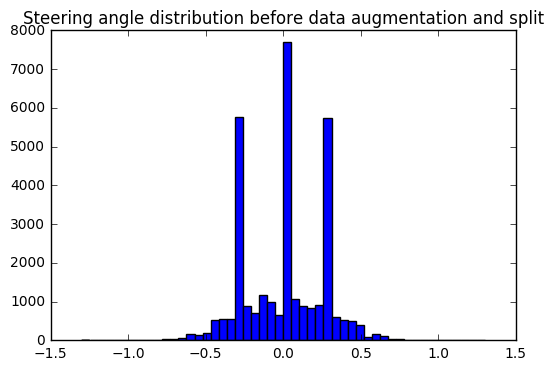

In [7]:
# After many-many iterations the following distribution of angles creates a decently balanced dataset.

y_train = y_train.astype(np.float)
print("len(y) :", len(y_train))
print("y.min() :", y_train.min())
print("y.max() :", y_train.max())

plt.hist(y_train, 50)
plt.title("Steering angle distribution before data augmentation and split")
plt.show()

In [8]:
model = Sequential([

    # Conv 5x5
    Convolution2D(24, 5, 5, border_mode='same', activation='elu', input_shape=(imgshape[0], imgshape[1], imgshape[2])),
    MaxPooling2D(border_mode='same'),

    # Conv 5x5
    Convolution2D(36, 5, 5, border_mode='same', activation='elu'),
    MaxPooling2D(border_mode='same'),
    
    # Conv 5x5
    Convolution2D(48, 5, 5, border_mode='same', activation='elu'),
    MaxPooling2D(border_mode='same'),
    
    # Conv 3x3
    Convolution2D(64, 3, 3, border_mode='same', activation='elu'),
    MaxPooling2D(border_mode='same'),
    SpatialDropout2D(0.2),
    
    # Conv 3x3
    Convolution2D(64, 3, 3, border_mode='same', activation='elu'),
    MaxPooling2D(border_mode='same'),
    SpatialDropout2D(0.2),
    
    # Flatten
    Flatten(),
    
    # Fully Connected
    Dense(100, activation='elu'),
    Dense(50, activation='elu'),
    Dense(10, activation='elu'),
    Dense(1)
])

In [10]:
print(X_train.shape)
# print(y_one_hot_train.shape)
print(y_train.shape)
X_train_nor = X_train #np.reshape(X_train, (X_train.shape[0], imgshape[0], imgshape[1], 1))
print(X_train_nor.shape)
y_train_nor = np.reshape(y_train, (y_train.shape[0], 1))
print(y_train_nor.shape)
model.compile('adam', 'mean_squared_error', [])
# print(y_one_hot_train.shape)
history = model.fit(X_train_nor, y_train_nor, batch_size=64, nb_epoch=5, validation_split=0.2)

(32144, 64, 64, 3)
(32144,)
(32144, 64, 64, 3)
(32144, 1)
Train on 25715 samples, validate on 6429 samples
Epoch 1/5
25715/25715 [==============================] - 9s - loss: 0.0306 - val_loss: 0.0338

In [11]:
json_string = model.to_json()
target = open("model.json", 'w')
target.write(json_string)
target.close()
model.save_weights("model.h5")

In [9]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 64, 64, 24)    1824        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 32, 32, 24)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 32, 36)    21636       maxpooling2d_1[0][0]             
____________________________________________________________________________________________________
maxpooling2d_2 (MaxPooling2D)    (None, 16, 16, 36)    0           convolution2d_2[0][0]            
___________________________________________________________________________________________